![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All imports

In [277]:
%load_ext autoreload
%autoreload 2

# Set up GPU rendering.
import distutils.util
import os
import subprocess
# # if subprocess.run('nvidia-smi').returncode:
# #   raise RuntimeError(
# #       'Cannot communicate with GPU. '
# #       'Make sure you are using a GPU Colab runtime. '
# #       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
  import mujoco.viewer # Also have to import this to trigger the installation of the viewer.
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np
# from scipy.spatial.transform import Rotation as Robj
from scipy.optimize import curve_fit, fsolve, least_squares
from scipy.signal import medfilt
from scipy.stats import linregress
from utils.helper_fns import *
from utils.render_opts import *
import utils.robot_controller as robot_controller
from load_obj_in_env import load_environment
# import utils.com_estimation as com
from utils.com_estimation import tau_model, tau_app_model, theta_from_tau, align_zeros

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import contextlib

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
# Set matplotlib font size
fonts = {'size' : 20}
plt.rc('font', **fonts)
%matplotlib inline
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


## Full Toppling Simulation

In [ ]:

# ======================== Toggle visualization here =========================
VIZ = True   # set to False to record video without showing the viewer
# ============================================================================

## Let's recall the model to reset the simulation
# 0: box_exp, 1: alarmclock, 2: binoculars, 3: camera, 4: elephant, 5: flashlight, 6: hammer, 7: waterbottle, 8: wineglass
model, data = load_environment(num=6, launch_viewer=False)


## Setup based on robot model
irb = robot_controller.controller(model, data)

## Set robot just in front of payload (same orientation as home position (facing +x))
T_init = np.eye(4)
T_init[0:3, 3] = np.array([0.95, 0.0, 0.3]) # tabl at 0.1 so this is z=0.2 for robot
q_init = irb.IK(T_init, method=2, damping=0.5, max_iters=1000) # DLS method
irb.set_pose(q=q_init)

# ## The end pose we want to reach FOR POSITION CONTROL (format: 4x4 matrix)
T_end = T_init.copy()
T_end[0, 3] += 0.15  # Move EE forward by 15 cm in x direction
target_q = irb.IK(T_end, method=2, damping=0.5, max_iters=1000)  # DLS method

## FOR VELOCITY CONTROL (format: [wx wy wz vx vy vz])
# target_vel  = np.array([0.0, 0.0, 0.0, 0.14, 0.0, 0.0])  # Move EE forward at 4 cm/s in x direction

## Initialize time, force and tilt history for plotting
t_hist      = np.empty((0,))
f_meas_hist = np.zeros((0,3))
th_hist     = np.empty((0,))
ee_hist     = np.empty((0,3)) # xyz of end effector

irb.ft_offset

traj_duration = 6.0 # seconds
run_duration = traj_duration + 2.0  # seconds

## Initialize contact vertices list for this time step
tip_edge_pairs = []

## Additions for video recording

rv = RendererViewerOpts(model, data, vis=VIZ)

# ===========================================================================
# with rv.viewer_ctx as viewer:
with rv: # enters viewer if vis=True, sets viewer opts, and readies offscreen renderer for video capture
    while rv.viewer_is_running() and not irb.stop and data.time < run_duration:
        irb.check_topple()                          # Check for payload topple condition

        # For vel ctrl, just set target velocity directly
        # irb.set_vel_ctrl(target_vel, damping=1e-6)  # Update velocity control

        # For pos ctrl, break target_q into steps. Use time to dictate trajectory progress
        if data.time < traj_duration:
            alpha = data.time / traj_duration
            interp_q = (1 - alpha) * q_init + alpha * target_q
        else:
            interp_q = target_q.copy()
        irb.set_pos_ctrl(interp_q, check_ellipsoid=False)                 # Update position control

        mujoco.mj_step(model, data)                 # Step the simulation
        
        # angle, axis = irb.get_payload_axis_angle()  # Get the axis and angle of tipping

        roll,pitch,yaw = irb.get_payload_rpy()

        f_meas_hist = np.vstack((f_meas_hist, irb.ft_get_reading().reshape(1,3)))
        th_hist     = np.append(th_hist, pitch) # angle)
        t_hist      = np.append(t_hist, data.time)
        # ee_hist     = np.vstack((ee_hist, irb.T[:3, 3].reshape(1,3)))
        ee_hist     = np.vstack((ee_hist, data.site_xpos[irb.ee_site].reshape(1,3)))

        # Define a CONE where CoM lies. Initially, cone is basically the entire positive z-axis from the object origin
        # tip_edge_verts = irb.get_tip_edge()         # (k,3)
        # if tip_edge_verts.shape == (2, 3):          # exactly two contacts
        #     tip_edge_pairs.append(tip_edge_verts.copy())

        rv.sync()                               # Update the interactive viewer (if present)
        rv.capture_frame_if_due(data)

# No need to close renderer since context manager handles it

# tip_edge_pairs = np.asarray(tip_edge_pairs, dtype=float)            # Convert to numpy array for easier indexing

print('\n\n======================================')
print(f'Simulation ended in t = {data.time:.2f} seconds.')
print('======================================')

# Play the movie
media.show_video(rv.frames, fps=rv.framerate)

Current directory: /home/airlab07/Documents/github/mujoco_irb120/scripts

IK finished, robot state restored.
**********************************

IK finished, robot state restored.
**********************************


Simulation ended in t = 1.08 seconds.


## Process Data to match exp. & Plot $F_x$ vs $\theta_p$ & find zero-crossing ($\theta_*$)

Contact detected at index 1636 (1.64 s)
Settling detected at index 7999 (8.00 s)
Analysis window will start at index 636 (0.64 s)

Calculated theta* = 15.99 degrees
Calculated zc = 0.174

Inverting the equation, 
Ground truth theta*: 18.43 degrees
Ground truth zc = 0.15 m



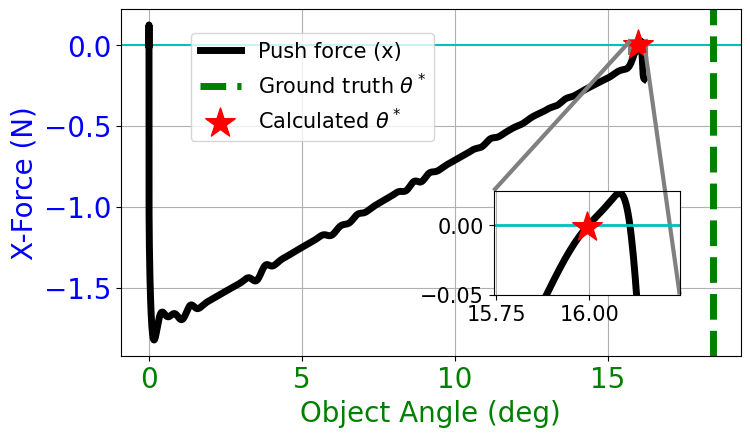

In [289]:
9# Let's try a Butterworth filter (same as experiment)
from scipy.signal import butter, filtfilt
b, a = butter(4, 6, fs=500, btype='low') # order, cutoff frequency, fs
f_meas_filt = filtfilt(b, a, f_meas_hist, axis=0)

# f_meas_filt = f_hist ## UNCOMMENT TO DISABLE FILTERING

# No need for interpolation to match shapes of f and theta

## ================ Find contact, settling, and start moments =================
contact_idx_og = np.argmax(np.linalg.norm(f_meas_filt, axis=1))
contact_time_og = t_hist[contact_idx_og]

# Let's find when the angle settles (for sim, its just the final time step)
settle_idx_og = len(t_hist) - 1
settle_time_og = t_hist[settle_idx_og]

# Define start of analysis window (a few seconds before contact)
start_time_og = contact_time_og - 1.0  # 1 second before contact
start_idx_og = np.where(t_hist >= start_time_og)[0][0]

print(f"Contact detected at index {contact_idx_og} ({contact_time_og:.2f} s)")
print(f"Settling detected at index {settle_idx_og} ({settle_time_og:.2f} s)")
print(f"Analysis window will start at index {start_idx_og} ({t_hist[start_idx_og]:.2f} s)")


## ===============================================================
# Analyze data and plot relationships
# Goal: Find theta_* and zc (and possibly mass)
## ===============================================================

# Find index of max force (after init transients) TODO: determine if this means f in x or norm
fmax_idx = np.argmax(np.linalg.norm(f_meas_filt, axis=1), axis=0)
# print(fmax_idx, f_hist_filt[fmax_idx])

# Then determine first zero-crossing of x-component of force (after initial transient)
f0_idx = fmax_idx + np.where(np.isclose(f_meas_filt[fmax_idx:,0], 0, atol=2e-3))[0][0]

## ==================== CALCULATE THETA* AND ZC ====================
theta_star_calc = th_hist[f0_idx]
print(f"\nCalculated theta* = {np.rad2deg(theta_star_calc):.2f} degrees")

xc_gt = 0.05
zc_calc = xc_gt / np.tan(theta_star_calc) # 0.05 is x_c (constant in object-fixed frame)
print(f"Calculated zc = {zc_calc:.3f}") # zc in meters

theta_star_gt = np.rad2deg(np.arctan2(0.05, 0.15))
print(f"\nInverting the equation, \nGround truth theta*: {theta_star_gt:.2f} degrees")
print(f'Ground truth zc = 0.15 m\n')


PLOT_XYZ = False
PLOT_F_TH = True

if PLOT_XYZ == True:
    # Now plot the force and pitch history vs time
    fig, ax1 = plt.subplots(figsize=(8, 4.5))
    # Horizontal line at zero for reference
    ax1.axhline(0, color='c', label='_')
    # Plot the force history
    ax1.plot(t_hist, f_meas_filt[:, 0], color='b', linewidth=5, label='Push force (x)')  # Plot the x-component of the force
    ax1.plot(t_hist, f_meas_filt[:, 1], color='r', linewidth=5, label='Push force (y)')  # Plot the y-component of the force
    ax1.plot(t_hist, f_meas_filt[:, 2], color='m', linewidth=5, label='Push force (z)')  # Plot the z-component of the force
    ax1.set_title('X, Y, Z Data Over Time')
    ax1.set_xlabel("Time (s)", fontsize=20)
    ax1.set_ylabel("Force (N)", color='b', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)
    # ax1.set_ylim(-0.1, 1.1 * np.max(np.linalg.norm(f_hist_filt, axis=1)))

    # Plot the pitch history on a secondary y-axis
    ax2 = plt.twinx()
    ax2.plot(t_hist, np.rad2deg(th_hist), color='g', linestyle='-.', linewidth=5, label='Object angle')      # Plot the object angle
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_ylabel("Object Angle (deg)", color='g', fontsize=20)
    # ax2.set_ylim(-5, 30) # max hardcoded for now, can change to 1.1*max_pitch later
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85), fontsize=15)

    # FOR PAPER FIGURE, TRIM THE TITLE AND AXES LIMITS
    ax1.set_title('')
    ax1.set_xlim(0, 4)
    ax2.set_ylim(0, 30)

    align_zeros([ax1, ax2])  # Align the y-axes to zero

if PLOT_F_TH == True:
    # Now plot force (in primary tipping axis) versus payload pitch
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.axhline(0, color='c') # Horizontal line at zero for reference
    ax.plot(np.rad2deg(th_hist[:f0_idx+100]), f_meas_filt[:f0_idx+100, 0], \
            color='k', linewidth=5, label='Push force (x)')  # Plot the x-component of the force (up to 100 indices after zero-crossing)
    ax.set_ylabel("X-Force (N)", color='b', fontsize=20)
    ax.set_xlabel("Object Angle (deg)", color='g', fontsize=20)
    ax.axvline(theta_star_gt, color='g', linestyle='--', linewidth=5, label=r'Ground truth $\theta^*$')
    ax.scatter(np.rad2deg(theta_star_calc), f_meas_filt[f0_idx,0], s=500, marker='*', color='r', label=r'Calculated $\theta^*$', zorder=2)
    
    ax.grid(True)
    fig.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.2, 0.85)) # # Now also plot a * at zero-crossing

    ax.tick_params(axis='y', labelcolor='b')
    ax.tick_params(axis='x', labelcolor='g')

    # ======= Same figure, add zoomed-in view around theta* ========
    # Choose x-lims around theta*
    x0 = np.rad2deg(max(th_hist.min(), theta_star_calc - np.deg2rad(0.25)))
    x1 = np.rad2deg(min(th_hist.max(), theta_star_calc + np.deg2rad(0.25)))
    # y-lims around bottom 10% of force
    y0 = -0.05
    y1 = 0.025

    # axins = inset_axes(ax3, width="30%", height="30%", loc='upper left')#, borderpad=2.2)
    axins = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=2.2)
    axins.plot(np.rad2deg(th_hist), f_meas_filt[:,0], color='k', linewidth=5)  # Plot the x-component of the force
    axins.scatter(np.rad2deg(theta_star_calc), f_meas_filt[f0_idx,0], s=500, marker='*', color='r', label=r'Calculated $\theta^*$', zorder=3)
    axins.axvline(theta_star_gt, color='g', linestyle='--', linewidth=5, label=r'Ground truth $\theta^*$')
    axins.axhline(0, color='c', linewidth=2) # Horizontal line at zero for reference
    axins.set_xlim(x0, x1)
    axins.set_ylim(y0, y1)
    axins.grid(True)
    axins.tick_params(axis='y', labelsize=15)
    axins.tick_params(axis='x', labelsize=15)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linewidth=3)


### Take a subset (if we only tipped to __% of $f_{max}$) and curve fit using physics

In order to do a curve fit, we need to provide decent data by trimming the initial transients
and the tailing residuals

In [12]:
## Now, 'OFFICIALY" chop off zero-force transients using f0_idx above
f_meas_filt = f_meas_filt[:f0_idx, :]
th_hist = th_hist[:f0_idx]
t_hist = t_hist[:f0_idx]
ee_hist = ee_hist[:f0_idx, :]

## NOTE: f_max may be negative, we want to consider magnitude for safe force calculation
k_safe = 0.25 # fraction of max force
f_safe_value = (1-k_safe) * f_meas_filt[fmax_idx,:]
print(f"Safe force threshold: {k_safe}% of f_max for f_safe= {f_safe_value} N")

# Extract subset of data where force exceeds safe threshold
idx_subcrit = np.where(np.linalg.norm(f_meas_filt, axis=1) >= np.linalg.norm(f_safe_value))[0]

# For curve fitting, we don't want the initial spike in force, let's scrub them (our cleaned data already starts with the spike at index 0 (relatively speaking))
init_spike_idx = 500 # 160  # Manually determined for now
idx_subcrit = idx_subcrit[init_spike_idx:]  # Keep indices 80 onward

## And capture the sub-critical force, theta, time, and EE pos values
f_subcrit = f_meas_filt[idx_subcrit, :]
th_subcrit = th_hist[idx_subcrit]
t_subcrit = t_hist[idx_subcrit]
ee_subcrit = ee_hist[idx_subcrit, :]

PLOT_SUBCRIT = False

if PLOT_SUBCRIT == True:
    # And plot
    fig4, ax4 = plt.subplots(figsize=(8, 4.5))
    ax4.plot(np.rad2deg(th_hist), np.linalg.norm(f_meas_filt, axis=1), color='k', linewidth=5, label='Simulated data')  # Plot the x-component of the force
    ax4.scatter(np.rad2deg(th_subcrit), np.linalg.norm(f_subcrit, axis=1), color='r', s=80, label='Sub-critical window')
    ax4.axhline(0, color='c', label='_')
    ax4.set_ylabel("Force Norm (N)", color='b', fontsize=20)
    ax4.set_xlabel("Object Angle (deg)", color='g', fontsize=20)
    ax4.legend(loc='upper right', fontsize=15)
    ax4.grid(True)

Safe force threshold: 0.25% of f_max for f_safe= [-1.014 -0.     0.003] N


## Fit using both $\theta$ and $F$ real data from sub-critical window

Initial guess from linear fit:
mass: 3.514 kg    zc: 0.692 m    theta*: 20.651 deg

Fit using TAU model:
mass: 0.641 kg    zc: 0.149 m    theta*: 18.53 deg

Ground Truth:
mass: 0.635 kg    zc: 0.150 m    theta*: 18.43 deg


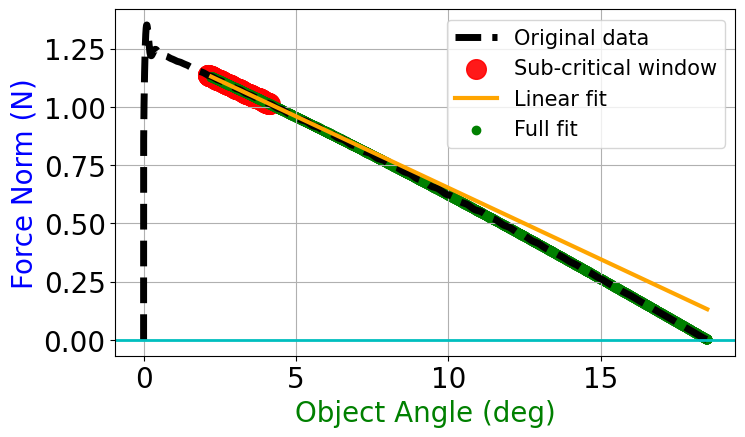

In [8]:
f_app_subcrit = -f_subcrit # NOTE: IMPORTANT NEGATE TO MATCH F OBJECT EXPERIENCES

## Start by fitting straight line to sub-critical data to get initial guess
lin_slope, lin_b, _, _, _ = linregress(th_subcrit, np.linalg.norm(f_app_subcrit, axis=1))

theta_star_guess = -lin_b / lin_slope

# tan(th) = d_c / z_c => z_c = d_c / tan(th)
dc_gt       = np.linalg.norm(np.array([-0.05, 0]))      # ground truth for d_c from 2D com estimation
zc_guess    = dc_gt / np.tan(th_subcrit[-1])
m_guess     = abs(lin_slope) #0.5                              # gt is 0.634 kg # TODO: Make better guess
print(f"Initial guess from linear fit:")
print(f"mass: {m_guess:.3f} kg    zc: {zc_guess:.3f} m    theta*: {np.rad2deg(theta_star_guess):.3f} deg")

   
## =============== Fit using TAU model ==================
# Before fitting, must pre-compute corresponding PUSH torque
tau_app_subcrit = tau_app_model(f_app_subcrit, (ee_subcrit - irb.o_obj)).ravel()

[m_est, zc_est], pcov  = curve_fit(tau_model, th_subcrit, tau_app_subcrit, p0=[m_guess, zc_guess])

# Now use fitted parameters to estimate theta_star
theta_star_est = np.rad2deg(np.arctan2(dc_gt, zc_est))

print(f"\nFit using TAU model:")
print(f"mass: {m_est:.3f} kg    zc: {zc_est:.3f} m    theta*: {theta_star_est:.2f} deg")
print(f"\nGround Truth:")
print(f"mass: {0.635} kg    zc: {com_gt[2]:.3f} m    theta*: {theta_star_gt:.2f} deg")

## ============================ PLOTTING ============================
# Let's plot the whole curve, the sub-critical window, the linear fit, and whole curve w fit params
f_app_full      = -f_meas_filt[fmax_idx+init_spike_idx:, :]
ee_full         = ee_hist[fmax_idx+init_spike_idx:, :]
tau_app_full    = tau_app_model(f_app_full, (ee_full - irb.o_obj))
# Extract theta from torque calculation
th_full         = theta_from_tau(tau_app_full, m_est, zc_est, use_branch='minus')
# Plot the linear fit using y = mx + b
f_app_lin = lin_slope * th_full + lin_b

## Plot original data and sub-critical window
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(np.rad2deg(th_hist), np.linalg.norm(f_meas_filt, axis=1), '--k', linewidth=5, label='Original data')  # Plot the x-component of the force
ax.scatter(np.rad2deg(th_subcrit), np.linalg.norm(f_app_subcrit, axis=1), color='r', s=200, alpha=0.9, label='Sub-critical window')

ax.plot(np.rad2deg(th_full), f_app_lin, color='orange', linewidth=3, label='Linear fit')
## FOR FUN, plot ALL theta and force
ax.scatter(np.rad2deg(th_full), np.linalg.norm(f_app_full, axis=1), color='g', label='Full fit')

ax.axhline(0, color='c', linewidth=2) # Horizontal line at zero for reference
ax.set_ylabel("Force Norm (N)", color='b', fontsize=20)
ax.set_xlabel("Object Angle (deg)", color='g', fontsize=20)
ax.legend(loc='upper right', fontsize=15)
ax.grid(True)


Initial guess from linear fit:
mass: 3.565 kg    zc: 0.692 m    theta*: 20.371 deg

Fit using TAU model:
mass: 0.641 kg    zc: 0.149 m    theta*: 18.53 deg

Ground Truth:
mass: 0.635 kg    zc: 0.150 m    theta*: 18.43 deg


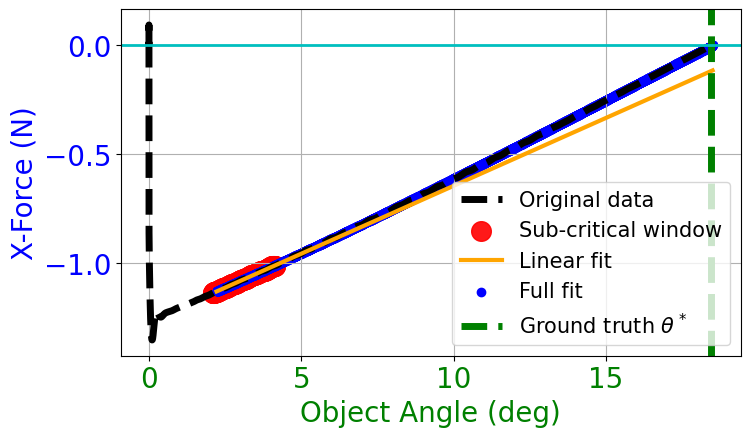

In [11]:
## AND now use ONLY the x-component of force (primary pushing axis)


f_app_subcrit = -f_subcrit # NOTE: IMPORTANT NEGATE TO MATCH F OBJECT EXPERIENCES

## Start by fitting straight line to sub-critical data to get initial guess
# lin_slope, lin_b, _, _, _ = linregress(th_subcrit, np.linalg.norm(f_app_subcrit, axis=1))
lin_slope, lin_b, _, _, _ = linregress(th_subcrit, f_app_subcrit[:,0])

theta_star_guess = -lin_b / lin_slope

# tan(th) = d_c / z_c => z_c = d_c / tan(th)
dc_gt       = np.linalg.norm(np.array([-0.05, 0]))      # ground truth for d_c from 2D com estimation
zc_guess    = dc_gt / np.tan(th_subcrit[-1])
m_guess     = abs(lin_slope) #0.5                              # gt is 0.634 kg # TODO: Make better guess
print(f"Initial guess from linear fit:")
print(f"mass: {m_guess:.3f} kg    zc: {zc_guess:.3f} m    theta*: {np.rad2deg(theta_star_guess):.3f} deg")

   
## =============== Fit using TAU model ==================
# Before fitting, must pre-compute corresponding PUSH torque
tau_app_subcrit = tau_app_model(f_app_subcrit, (ee_subcrit - irb.o_obj)).ravel()

[m_est, zc_est], pcov  = curve_fit(tau_model, th_subcrit, tau_app_subcrit, p0=[m_guess, zc_guess])

# Now use fitted parameters to estimate theta_star
theta_star_est = np.rad2deg(np.arctan2(dc_gt, zc_est))

print(f"\nFit using TAU model:")
print(f"mass: {m_est:.3f} kg    zc: {zc_est:.3f} m    theta*: {theta_star_est:.2f} deg")
print(f"\nGround Truth:")
print(f"mass: {0.635} kg    zc: {com_gt[2]:.3f} m    theta*: {theta_star_gt:.2f} deg")

## ============================ PLOTTING ============================
# Let's plot the whole curve, the sub-critical window, the linear fit, and whole curve w fit params
f_app_full      = -f_meas_filt[fmax_idx+init_spike_idx:, :]
ee_full         = ee_hist[fmax_idx+init_spike_idx:, :]
tau_app_full    = tau_app_model(f_app_full, (ee_full - irb.o_obj))
# Extract theta from torque calculation
th_full         = theta_from_tau(tau_app_full, m_est, zc_est, use_branch='minus')
# Plot the linear fit using y = mx + b
f_app_lin = lin_slope * th_full + lin_b

## Plot original data and sub-critical window
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(np.rad2deg(th_hist), f_meas_filt[:,0], '--k', linewidth=5, label='Original data')  # Plot the x-component of the force
ax.scatter(np.rad2deg(th_subcrit), -f_app_subcrit[:,0], color='r', s=200, alpha=0.9, label='Sub-critical window')

ax.plot(np.rad2deg(th_full), -f_app_lin, color='orange', linewidth=3, label='Linear fit')
## FOR FUN, plot ALL theta and force
ax.scatter(np.rad2deg(th_full), -f_app_full[:,0], color='b', label='Full fit')
ax.axvline(theta_star_gt, color='g', linestyle='--', linewidth=5, label=r'Ground truth $\theta^*$')

ax.axhline(0, color='c', linewidth=2) # Horizontal line at zero for reference
ax.set_ylabel("X-Force (N)", color='b', fontsize=20)
ax.set_xlabel("Object Angle (deg)", color='g', fontsize=20)
ax.legend(loc='lower right', fontsize=15)

ax.tick_params(axis='y', labelcolor='b', labelsize=20)
ax.tick_params(axis='x', labelcolor='g', labelsize=20)

ax.grid(True)


In [ ]:


# ============================ PLOTTING (enhanced) ============================
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

th_full_deg = np.rad2deg(th_full)
F_full = np.linalg.norm(f_app_full, axis=1)

# ================= main + residuals =================
fig, (ax, axr) = plt.subplots(2, 1, sharex=False, figsize=(9, 6),
                              gridspec_kw={'height_ratios': [3, 1]})

# main plot
ax.plot(np.rad2deg(th_hist), np.linalg.norm(f_meas_filt, axis=1),
        '--k', lw=3, alpha=0.5, label='Original data')

ax.scatter(np.rad2deg(th_subcrit), np.linalg.norm(f_app_subcrit, axis=1),
           c='r', s=40, alpha=0.8, label='Sub-critical window')

ax.plot(th_full_deg, f_app_lin, color='orange', lw=2.5, alpha=0.7, label='Linear fit')
ax.scatter(th_full_deg, F_full, c='g', s=18, alpha=0.6, label='Full (measured)')

ax.axhline(0, color='c', lw=1.5)
ax.set_ylabel("Force Norm (N)", fontsize=14, color='b')
ax.set_xlabel("Object Angle (degrees)", fontsize=14, color='g')
ax.legend(loc='upper right', fontsize=11, frameon=False)
ax.grid(True, alpha=0.3)

# residuals (data - linear fit) for the full region
resid = F_full - f_app_lin
# resid = np.linalg.norm(f_app_full) - f_app_subcrit
axr.plot(th_full_deg, resid, color='orange', lw=1.8)
axr.axhline(0, color='k', lw=1)
axr.set_ylabel("Residual", fontsize=12)
axr.set_xlabel("Object Angle (deg)", fontsize=12)
axr.grid(True, alpha=0.3)

# ================= zoomed inset near low-force / tipping =================
# pick a window around small forces or near theta*
theta_star_est = np.degrees(np.arctan2(abs(np.array([-0.05, 0, 0])[0]), zc_est))  # ~deg
# choose x-lims around theta*; widen a bit and clamp to data range
x0 = max(th_full_deg.min(), theta_star_est - 4.0)
x1 = min(th_full_deg.max(), theta_star_est + 4.0)
# y-lims around the lower 20% of force range
ymin = max(0.0, F_full.min() - 0.05*(F_full.max()-F_full.min()))
ymax = F_full.min() + 0.25*(F_full.max()-F_full.min())

axins = inset_axes(ax, width="40%", height="40%", loc='lower left', borderpad=1.0)
axins.plot(th_full_deg, f_app_lin, color='orange', lw=2.0, alpha=0.9)
axins.scatter(th_full_deg, F_full, c='g', s=12, alpha=0.6)
axins.set_xlim(x0, x1)
axins.set_ylim(ymin, ymax)
axins.grid(True, alpha=0.3)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


In [5]:
## Fit using FORCE model
m_est_f, zc_est_f, result = fit_mass_and_zc(th_subcrit, f_app_subcrit, m_guess=m_guess, zc_guess=zc_guess)
print(f"Fit using FORCE model: mass: {m_est_f:.3f} kg    zc: {zc_est_f:.3f} m")
# Use fitted parameters to generate estimated FORCE values over sub-critical THETA data
# push_dirs = -f_sub_crit/np.linalg.norm(f_sub_crit, axis=1, keepdims=True)
push_dirs = np.array([1, 0, 0])
f_pred_fit = F_model(th_subcrit, m_est_f, zc_est_f, push_dirs=push_dirs)
# IMPORTANT: flip sign to convert back to measured force direction
f_pred_fit *= -1

# Let's plot against (sub-critical) time for better visualization

# Quick check what F looks like at theta ~= 0
th_temp = 19
F_temp = F_model(np.deg2rad(th_temp), m_est_f, zc_est_f, push_dirs=np.array([1,0,0]))
print(f"At theta={th_temp}, F_model predicts F = {F_temp} N")

fig, ax = plt.subplots(figsize=(16,9))#  8, 4.5))
# Plot the original data
ax.plot(t_subcrit, f_app_subcrit[:,0], color='b', linewidth=2, label='Simulated data (x-comp)')
ax.plot(t_subcrit, f_app_subcrit[:,1], color='r', linewidth=2, label='Simulated data (y-comp)')
ax.plot(t_subcrit, f_app_subcrit[:,2], color='m', linewidth=2, label='Simulated data (z-comp)')
ax.plot(t_subcrit, np.linalg.norm(f_app_subcrit, axis=1), color='k', linewidth=2, label='Simulated data (norm)')
# Plot the estimates
ax.plot(t_subcrit, f_pred_fit[:,0], color='b', linewidth=2, linestyle='--', label='Fitted FORCE model (x-comp)')
ax.plot(t_subcrit, f_pred_fit[:,1], color='r', linewidth=2, linestyle='--', label='Fitted FORCE model (y-comp)')
ax.plot(t_subcrit, f_pred_fit[:,2], color='m', linewidth=2, linestyle='--', label='Fitted FORCE model (z-comp)')
ax.plot(t_subcrit, np.linalg.norm(f_pred_fit, axis=1), color='k', linewidth=2, linestyle='--', label='Fitted FORCE model (norm)')
# ax.axhline(0, color='c', linewidth=2) # Horizontal line at zero for reference
ax.set_xlabel("Time (s)", color='k', fontsize=20)
ax.set_ylabel("Force (N)", color='k', fontsize=20)
ax.grid(True)

ax2 = plt.twinx()
# ax2.plot(t_sub_crit, np.rad2deg(th_sub_crit), color='g', linewidth=2, linestyle='--', label='Payload Pitch (deg)')
ax2.plot(t_all, np.rad2deg(th_all), color='g', linewidth=2, linestyle='--', label='Payload Pitch (deg)')
ax2.set_ylabel("Payload Pitch (deg)", color='g', fontsize=20)
# ax2.tick_params(axis='y', labelcolor='g')
fig.legend(loc='upper left', fontsize=15)

NameError: name 'fit_mass_and_zc' is not defined